# Setup

📝 *Import required libraries and files:*

In [1]:
#   === Build Sentiment Analysis ===
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#   === Competitive Analysis ===
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display

In [2]:
path = "C:/Users/pedro/Projects/banking_app_reviews/assets/df_clean.parquet"
df_clean = pd.read_parquet(path)
print(f"df shape: {df_clean.shape}")
df_clean.head(2)

df shape: (703563, 15)


,review_id,app,score,review_text,review_text_clean,review_date,year,thumbs_up,replied,reply_text,reply_text_clean,reply_date,time_to_reply(h),app_version_head,app_version_detail
0,1,Santander,5,"very easy to use app, very happy with it","very easy to use app, very happy with it",2025-09-04 14:21:00,2025,0,1,"Hi! Thanks for the 5* review, we're so glad to...","hi! thanks for the 5* review, we're so glad to...",2025-09-04 14:40:12,0.32,5,24.0
1,2,Santander,3,New 2024 app is slow to open. Too much whitesp...,new 2024 app is slow to open. too much whitesp...,2025-09-04 13:36:26,2025,3,1,Hey there! All feedback is greatly appreciated...,hey there! all feedback is greatly appreciated...,2024-04-29 14:16:29,-11831.33,5,24.0


# 3 - Sentiment Analysis

## 3.1. - Building Sentiment Analaysis

### 3.1.1. - Sentiment Intensity Analyser using VADER 

We will perform sentiment analysis using VADER's `SentimentIntensityAnalyzer`.

In [3]:
def add_vader_sentiment(
    df: pd.DataFrame,
    text_col: str = "review_text",
    score_col: str = "review_sentiment",
    analyzer: SentimentIntensityAnalyzer | None = None,
    inplace: bool = True,
):
    """
    Adds two columns:
      - '*_sentiment': VADER compound score in [-1, 1] (NaN for empty/invalid)
      - '*_sentiment_label': 'positive' | 'negative' | 'neutral' | 'undefined'
      - Consistent (int): 1 if sentiment label aligns with numeric score, else 0
    """
    if not inplace:
        df = df.copy()

    if analyzer is None:
        analyzer = SentimentIntensityAnalyzer()

    # 1) sentiment scores (numeric; NaN for undefined)
    def _score(text):
        if not isinstance(text, str) or text.strip() == "":
            return np.nan
        return analyzer.polarity_scores(text)["compound"]

    df[score_col] = [ _score(t) for t in df[text_col] ]

    # 2) sentiment labels
    def _label(s):
        if pd.isna(s):
            return "undefined"
        if s >= 0.10:
            return "positive"
        if s <= -0.10:
            return "negative"
        return "neutral"

    label_col = f"{score_col}_label"
    df[label_col] = pd.Categorical([ _label(s) for s in df[score_col] ],
                                   categories=["negative","neutral","positive","undefined"])
    
    # 3) Consistency check
    def _consistent(row):
        if row[label_col] == "positive" and row["score"] in (0, 1):
            return 0
        if row[label_col] == "negative" and row["score"] in (4, 5):
            return 0
        return 1

    df["Consistent"] = df.apply(_consistent, axis=1).astype(int)

    # --- Save Final Dataframe ---
    save_path = "../assets/df_sentiment.parquet"
    df.to_parquet(save_path, index = False)
    print(f"✅ Dataframe saved in {save_path}")
    print(f"df saved shape: {df.shape}")

    return df

In [4]:
df_clean = add_vader_sentiment(df_clean, text_col="review_text_clean", score_col="review_sentiment")
df_clean = add_vader_sentiment(df_clean, text_col="reply_text_clean", score_col="reply_sentiment")

✅ Dataframe saved in ../assets/df_sentiment.parquet
df saved shape: (703563, 18)
✅ Dataframe saved in ../assets/df_sentiment.parquet
df saved shape: (703563, 20)


In [5]:
print("Review Sentiment Label:")
print(df_clean['review_sentiment_label'].value_counts().sum)
print("------------------")
print(df_clean['reply_sentiment_label'].value_counts().sum)

Review Sentiment Label:
<bound method Series.sum of review_sentiment_label
positive     544533
neutral       86873
negative      72087
undefined        70
Name: count, dtype: int64>
------------------
<bound method Series.sum of reply_sentiment_label
undefined    595155
positive     100410
negative       4724
neutral        3274
Name: count, dtype: int64>


### 3.1.2. - Check rows with undefined sentiment

The large number of replies with "undefined" sentiment is related with reviews with no reply and, therefore, no sentiment can be attributed. 

Let's explore reviews with undefined sentiment scores:

In [6]:
subset = df_clean.loc[df_clean['review_sentiment_label'].eq('undefined'), ['review_id','score', 'review_text','review_text_clean', 'review_sentiment_label']]
sample = subset.sample(n=min(20, len(subset)), random_state=42)
sample

,review_id,score,review_text,review_text_clean,review_sentiment_label
198418,208966,5,None,None,undefined
4182,4183,5,None,None,undefined
447497,549813,4,None,None,undefined
25257,25258,2,None,None,undefined
456778,559094,1,None,None,undefined
152293,162841,5,None,None,undefined
53317,53318,5,None,None,undefined
307424,351407,4,None,None,undefined
414277,458260,5,None,None,undefined
112137,122685,5,None,None,undefined


As it can be seen, the situations with no sentiment score are given by: 1. reviews that are emmpty; 2. reviews that are just emojis (that were cleaned prior to apply VADER's sentiment analysis); 3. reviews that are writen in unrecognized characters. 

In [7]:
# Make sure undefined_text is a DataFrame
undefined_text = df_clean[df_clean['review_sentiment_label'] == 'undefined']
# Count total reviews per app
total_reviews_by_app = df_clean.groupby('app').size()
# Count undefined sentiment per app
undefined_text_by_app = undefined_text.groupby('app').size()
# Calculate percentage
undefined_percent = (undefined_text_by_app / total_reviews_by_app * 100).round(2)

# Combine into a single DataFrame
summary = pd.DataFrame({
    'undefined_count': undefined_text_by_app,
    'total_reviews': total_reviews_by_app,
    'percent_undefined': undefined_percent
}).fillna(0).astype({'undefined_count': int, 'total_reviews': int})

# Add total row
total_row = pd.DataFrame({
    'undefined_count': [summary['undefined_count'].sum()],
    'total_reviews': [summary['total_reviews'].sum()],
    'percent_undefined': [(summary['undefined_count'].sum() / summary['total_reviews'].sum() * 100).round(2)]
}, index=['TOTAL'])

summary = pd.concat([summary, total_row])

# Show result
summary

,undefined_count,total_reviews,percent_undefined
Barclays,21,205758,0.01
HSBC,1,38622,0.00
LLoyds,14,114260,0.01
Monzo,2,21227,0.01
Revolut,21,254287,0.01
Santander,11,69409,0.02
TOTAL,70,703563,0.01


When we look at the total numbers adding all bank apps, they represent just 0.5% of the total reviews. **Given their reduced weight we will ignore the situations of "undefined" sentiment for the purpose of this sentiment analysis**.

## 3.2. Competitive Analysis of Reviews' text sentiment

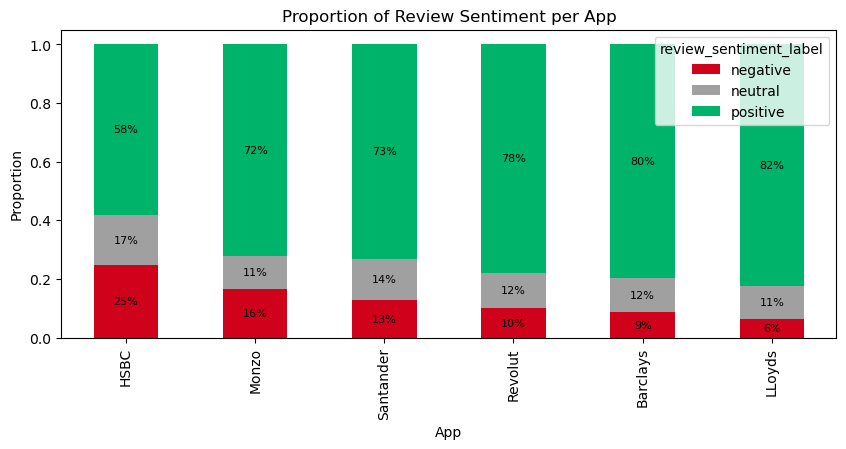

In [8]:
# Keep only wanted labels and make them the only categories (order set too)
wanted = ['negative', 'neutral', 'positive']
valid = df_clean[df_clean['review_sentiment_label'].isin(wanted)].copy()
valid['review_sentiment_label'] = pd.Categorical(valid['review_sentiment_label'],
                                                 categories=wanted, ordered=True)

# Count and proportion – only observed categories will be used (no 'undefined' column)
sentiment_counts = (valid
    .groupby(['app', 'review_sentiment_label'], observed=True)
    .size()
    .unstack(fill_value=0))

sentiment_props = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sort by share of negatives (desc)
sentiment_props = sentiment_props.sort_values(by='negative', ascending=False)

# Colors only for the columns that actually exist
color_map = {'negative': '#d0021b', 'neutral': '#a0a0a0', 'positive': '#00b36b'}
colors = [color_map[c] for c in sentiment_props.columns]  # safe now

# Plot
ax = sentiment_props.plot(kind='bar', stacked=True, figsize=(10, 4), color=colors)
ax.set_xlabel('App'); ax.set_ylabel('Proportion'); ax.set_title('Proportion of Review Sentiment per App')

# annotate bars
for p in ax.patches:
    if p.get_height() > 0.02:
        ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2,
                f"{p.get_height():.0%}", ha='center', va='center', fontsize=8)

plt.show()

The **sentiment analysis results seem to be logically consistent with the average review scores** we had calculated for each banking app in previous notebook. This allow us to confirm what we already expected: **scores are a very strong predictor of text sentiment** (and vice versa), which is logical, otherwise the user review would be inconsistent. In that sense, it can be argued that performing sentiment analysis when we already have review scores can be add limited extra value. Nevertheless, let's check below eventual "score / sentiment" inconsistencies for each app to detect:

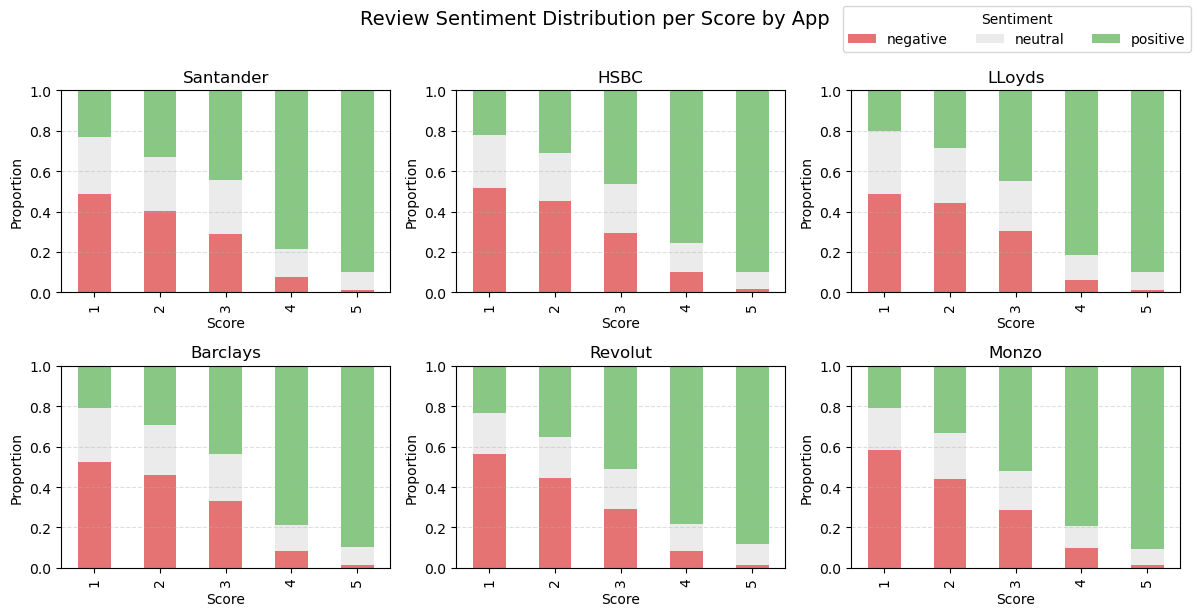

In [9]:
valid = df_clean.copy()

# ensure columns exist and are in the right types
valid['score'] = pd.to_numeric(valid['score'], errors='coerce')
valid = valid.dropna(subset=['score'])
valid['review_sentiment_label'] = valid['review_sentiment_label'].astype('category')

apps = valid['app'].dropna().unique()
sentiment_order = ['negative', 'neutral', 'positive']
COLORS = {'negative': '#e57373', 'neutral': '#ebebeb', 'positive': '#88c784'}

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, app_name in enumerate(apps):
    ax = axes[i]
    app_data = valid.loc[valid['app'] == app_name]

    # counts per score x sentiment
    counts = (
        app_data
        .groupby(['score', 'review_sentiment_label'], observed=True) 
        .size()
        .unstack(fill_value=0)
        .reindex(columns=sentiment_order, fill_value=0)               
        .sort_index()
    )

    # proportions per score
    props = counts.div(counts.sum(axis=1), axis=0).fillna(0)

    # plot
    props.plot(kind='bar', stacked=True,
               color=[COLORS[s] for s in sentiment_order],
               ax=ax, legend=False)

    ax.set_title(f"{app_name}")
    ax.set_xlabel("Score"); ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1); ax.grid(axis='y', linestyle='--', alpha=0.4)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, sentiment_order, title='Sentiment', loc='upper right', ncol=3)
plt.suptitle("Review Sentiment Distribution per Score by App", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

The graphs above confirm: i) strong correlation between scores and sentiments, with evidence that reviews with negative sentiment decrease as scores increase; ii) the pattern of the "score/sentiment" relation does not change much between different banking apps; iii) despite what is stated in the first point, there are still some incoherences of reviews with score 1 and apparently positive sentiment. 

This exceptional inconsitencies may occur due to several reasons such as:

1. **User mistakenly gave a score that he/she didn't mean to give**: the comment is clearly positive (e.g., "best of the best", "easy to see and manage my accounts in one easy to use app") but the score is not aligned with that;

2. **Positive sentiment was attributed incorrectly**: often, users talk good about previous versions of the app to make their point that the actual version is not good, which confuses the NLP model (e.g., "used to be a 5 star app until last update (...)", "it was a briliant and handy app until last update (...)")

3. **Usage of irony and sarcams**: some users make their point using irony and sarcasm, which leads to confusion for the NLP model ("...using it if you love being inconvenienced its first class", "...its an absolute joke it would be nice if it were possible to bank on my phone like other people in the 21st century...").

Point 2 could be significanlty mitigated by using more robust models - either more advanced NLP or LLM-based approaches. Point 3 could also benefit from this, although sarcasm and irony remain difficult to detect even for more sophisticated models. Regarding Point 1, we could potentially correct misclassifications if the score is an obvious mistake, but we would still face the challenge of having to subjectively define what a 1-to-5 score should mean based on the text.

Given the purpose of the next stage of the project - i.e., 'Topic Modeling' - is to generalize what are the main motives for users to be (dis)satified with the App in the reviews they share, we will **discart all the `inconsistent_cases`** (i.e., negative score / positive sentiment or positive score / negative sentiment) **from the topic modeling analysis**. 

In the end, this analysis on the inconsistent cases, proves that **sentiment analysis can still play a relevant role prior to topic modeling**, even when we already have a score, in order to eliminate records that could generate unnecessary “noise” and harm the effectiveness of the model. This is especially relevant when using less advanced NLP models that, given their limitations, can lead to the kind of misclassifications we’ve seen above.

## 3.3. Competitive Analysis of Replies' text sentiment

Before moving on to topic modeling, let's also analyze the sentiment of the replies — when they exist — that were provided by the banks in response to user reviews.

In this phase, we will evaluate two main questions:

- Are there differences in the overall positivity of the tone used by each bank in their replies?

- How does the tone of the reply vary depending on the score given by the user?

**Are there differences in the overall positivity of the tone used by each bank in their replies?**

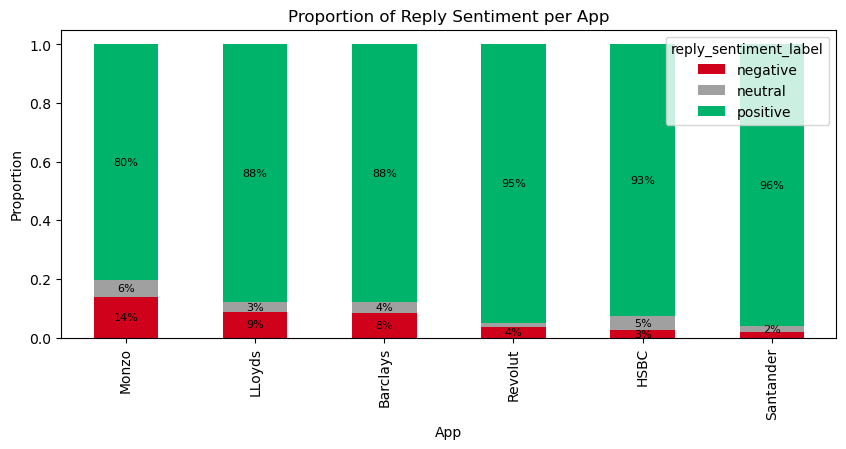

In [10]:
# Keep only wanted labels and make them the only categories (order set too)
wanted = ['negative', 'neutral', 'positive']
valid = df_clean[df_clean['reply_sentiment_label'].isin(wanted)].copy()
valid['reply_sentiment_label'] = pd.Categorical(valid['reply_sentiment_label'],
                                                 categories=wanted, ordered=True)

# Count and proportion – only observed categories will be used (no 'undefined' column)
sentiment_counts = (valid
    .groupby(['app', 'reply_sentiment_label'], observed=True)
    .size()
    .unstack(fill_value=0))

sentiment_props = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sort by share of negatives (desc)
sentiment_props = sentiment_props.sort_values(by='negative', ascending=False)

# Colors only for the columns that actually exist
color_map = {'negative': '#d0021b', 'neutral': '#a0a0a0', 'positive': '#00b36b'}
colors = [color_map[c] for c in sentiment_props.columns]  # safe now

# Plot
ax = sentiment_props.plot(kind='bar', stacked=True, figsize=(10, 4), color=colors)
ax.set_xlabel('App'); ax.set_ylabel('Proportion'); ax.set_title('Proportion of Reply Sentiment per App')

# annotate bars
for p in ax.patches:
    if p.get_height() > 0.02:
        ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2,
                f"{p.get_height():.0%}", ha='center', va='center', fontsize=8)

plt.show()

While in the users' review there was a direct link between the banks average review score and the review sentiment, in this case the relation seems to be less obvious. For example, we've seen before that Lloyds app is the one with highest average score, but it is also the app where the bank's replies have a negative sentiment in more ocasions. On the other side, HSBC which exhibited the worst average score, is the second bank with less negative sentiment in the replies given by the bank.

**How does the tone of the reply vary depending on the score given by the user?**

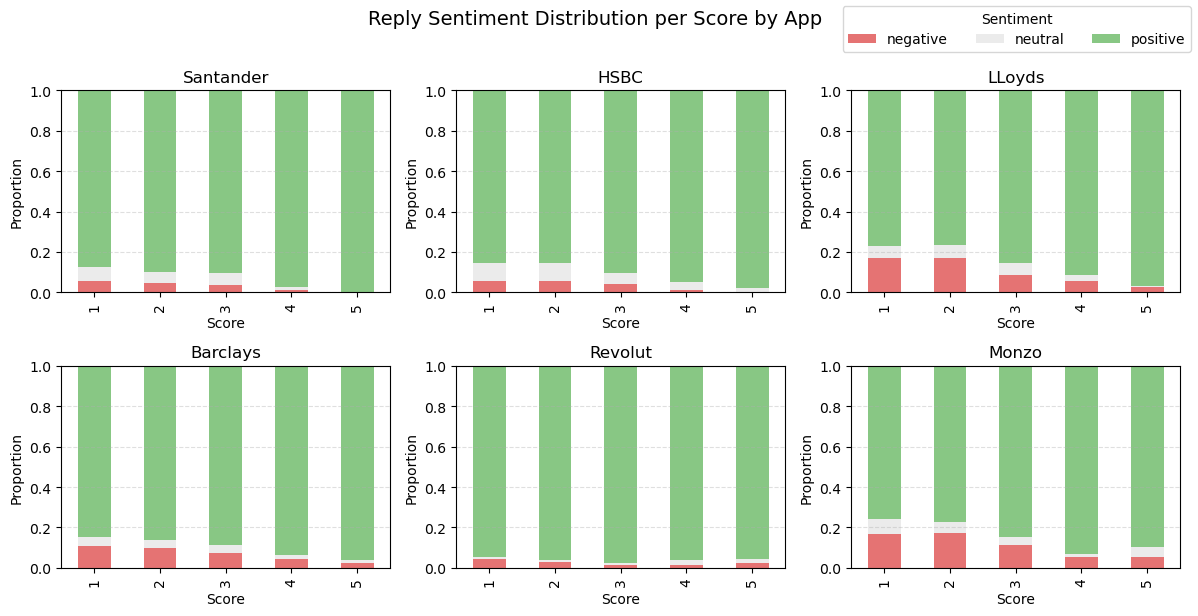

In [11]:
valid = df_clean.copy()

# ensure columns exist and are in the right types
valid['score'] = pd.to_numeric(valid['score'], errors='coerce')
valid = valid.dropna(subset=['score'])
valid['reply_sentiment_label'] = valid['reply_sentiment_label'].astype('category')

apps = valid['app'].dropna().unique()
sentiment_order = ['negative', 'neutral', 'positive']
COLORS = {'negative': '#e57373', 'neutral': '#ebebeb', 'positive': '#88c784'}

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, app_name in enumerate(apps):
    ax = axes[i]
    app_data = valid.loc[valid['app'] == app_name]

    # counts per score x sentiment
    counts = (
        app_data
        .groupby(['score', 'reply_sentiment_label'], observed=True) 
        .size()
        .unstack(fill_value=0)
        .reindex(columns=sentiment_order, fill_value=0)               
        .sort_index()
    )

    # proportions per score
    props = counts.div(counts.sum(axis=1), axis=0).fillna(0)

    # plot
    props.plot(kind='bar', stacked=True,
               color=[COLORS[s] for s in sentiment_order],
               ax=ax, legend=False)

    ax.set_title(f"{app_name}")
    ax.set_xlabel("Score"); ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1); ax.grid(axis='y', linestyle='--', alpha=0.4)

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, sentiment_order, title='Sentiment', loc='upper right', ncol=3)
plt.suptitle("Reply Sentiment Distribution per Score by App", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

We can conclude from the graphs above: 

1. **replies with negative sentiment are concentrated in reviews with scores between 1 and 3**, being almost inexistent while replying to reviews with scores of 4 or 5;

2. **regardless of the score, Lloyds and Monzo have a tendency to have more replies with a negative sentiment** than other banks.

To further understand this phenomenon let's analyze samples of replies with negative sentiment:

In [12]:
# Filter negative sentiment replies: negative reply sentiment regardless of the score
neg_reply = df_clean[df_clean['reply_sentiment_label'] == 'negative']

# Random sample
sample_neg_reply= neg_reply[['app', 'score', 'review_text', 'review_sentiment_label','reply_text', 'reply_sentiment_label']].sample(n=15, random_state=42)
pd.set_option('display.max_colwidth', None)
display.display(sample_neg_reply)

,app,score,review_text,review_sentiment_label,reply_text,reply_sentiment_label
17552,Santander,1,"Circle of death, again and again and again. I've been in some awkard situations over the past month where I've attempted to pay a person and all I get is the spinning circle followed by ""oops something went wrong"" The app is fully up to date. Get this sorted ASAP please. It's terrible!",negative,"Hi Jenna, we're sorry to hear this! The next step is to uninstall then reinstall the app to see if this makes a difference. If not, please contact us on 0330 123 0209 to raise this. ^MS",negative
380092,Barclays,1,Keeps getting closed can't use at all I mean when I open to transfer money or add new payee I have to try 20 times. App keeps closing everytime.,neutral,"Ahh I'm sorry you're getting this error, Rakshith. Is this still ongoing? If so can you reach out to our tech team on 0333 200 1014 (24/7) so they can take a closer look at it for you? –Amiee",negative
698741,Monzo,1,very bad service. blocked my account for no valid reason. they are holing my money. i am self employed and need to pay my goverment taxes they are stopping me from doing that. they wont give me back my money. shame on you money thiefing company.,negative,We're really sorry to hear about this 😞 If you need our team to look into this for you please drop an email to help@monzo.com and we'll see what we can do to help 🙏,negative
357532,Barclays,1,5 months on and still the worst banking app out.. Terrible service and no support except for the useless call agents.. Word of warning fo not download this and bank elsewhere 1. Behind on tech 2. Help agents are useless and lie to get you off the phone 3. They do not take any complaints seriously Go to one of the other large banks HSBC or Natwest I'd recommend.. Still the worst banking app out there.. barclays sort yourself out you are far behind your competitors,negative,"Hi there, I'm sorry to hear the app is causing frustration. Are you unable to log in or register? Let us know if you are being shown any error codes at all. Also is this a new issue or has it been causing technical difficulties for a while? Let us know to see if we can re solve this for you. Thank you for your feedback - JP",negative
101157,HSBC,1,the problem is that you cant scroll on the logging screen. I need to press need to generate new code. but the screen doesn't scroll to be able to press the other options. I've tried the app on my tablet and it works fine. I have reinstalled but no joy. The app worked on my s8+ but I now have a s10 and am having the issues,negative,Tim seems like you need to call us on 03456 002 290 and one of our agents can trouble shoot and get a resolution for you. ^Michelle,negative
20066,Santander,1,Used to be a good app now it's complete rubbish whenever I go to log in it's say error please close app and retry.,positive,"Hey Dean, we are sorry to hear this! If you get in touch with our team on 0330 123 0209 and a colleague of ours can assist. ^JS",negative
71884,HSBC,1,"Update: trying to pay in a cheque and it won't accept the photos or just logs me out half way through. I'm using a samsung S25 so not the pixel issue previously reported and yes, all software is upto date Further update: lighting and quality of image isn't the issue, the app just falls over. Visiting a branch isn't easy as you closed all the ones near me",negative,"Thank you for letting me know about your cheque deposit issue, Mike. I completely understand how frustrating this can be. Please try taking photos in a well-lit area and use a dark, non-reflective surface for the cheque. If these don't work, please free to visit your nearest HSBC UK branch by visiting www.hsbc.co.uk/branch-finder/. Thank you. -Jack",negative
691639,Monzo,1,I am trying to open an account but they are naot allowing me . And even not giving the reason why .,negative,"Hi Tooba 👋 We're sorry to hear that we couldn't open an account for you 😔 We wouldn't be able to look into this here du

As it can be seem, replies with negative sentiment do not mean that the banks' agent was rude or was not empatic with the user. Instead, the model interpreted these replies as "negative sentiment" due to the type of words used in the answers, that in these cases empathized understanding the "troubles", "frustration" or "inconvenience" caused to the customer.

In the end, from this quick exploration, it seems that when analysing the replies, **the `reply_sentiment` is more related to the bank's writing style and less to do with the politeness of the answer**. 

Below some examples of reviews with low score and positive `reply_sentiment` where typically the bank gave more emphasis on thanking the customer for the feedback and less on acknowledging the frustration caused to the customer:

In [13]:
# Filter negative sentiment replies: negative reply sentiment regardless of the score
reply_neg_feedback = df_clean[(df_clean['reply_sentiment_label'] == 'positive') & (df_clean['score'] == 1)]

# Random sample
sample_neg_reply = reply_neg_feedback  [['app', 'score', 'review_text', 'review_sentiment_label','reply_text','reply_sentiment_label']].sample(n=10, random_state=42)
pd.set_option('display.max_colwidth', None)
display.display(sample_neg_reply)

,app,score,review_text,review_sentiment_label,reply_text,reply_sentiment_label
88338,HSBC,1,"Terrible it keeps crashing so I've had to reinstall it. Trouble is without the app you can't even log on online. Nice one, nobody can access their bank accounts.",negative,"Hi Ellen, please generate the login code with your digital secure key password instead of using biometrics. This usually works to get access to the main website. We are working to fix the issue. ^Alison.",positive
529754,Revolut,1,"Signed up to receive my USD salary into a USD account. Only after signing up and going through verification was it made clear that isn't possible, which makes this pretty useless. And now they've got all my data for 6 years.",positive,"Hello! We're sorry to hear that. Rest assured that it's possible to receive transfers in USD currency into the USD account. All you need to do, is to provide the sender with USD account details which can be checked on the Home page > change the currency to USD > tap on the 3 dots visible next to the USD balance > account details will be displayed.",positive
351694,Barclays,1,Zero customer service They blocked my account for transferring my own money to my other account. Its been 2 hrs i am on call with them and call os still on hold Will close my account soon,negative,"Hi there, I'm sorry to hear the app is causing frustration. Did you make this transfer using the app initially? Let us know to see if we can resolve this for you. Thank you for your feedback - JP",positive
512203,Revolut,1,Awful,negative,"Hi! We’re sorry that your experience with us resulted in this review. We’d love to hear more feedback from you. Could you drop us a message via in-app chat? You can get there by heading to your profile profile section -> help -> ""get more help and contact us"" -> choose the topic of your inquiry-> type in ""live agent""",positive
298774,Barclays,1,Rubbish,neutral,"Hi Dave. Thank-you for reaching out. Please let us know what exactly is causing your frustration with the app, so that we can work towards resolving for you. Many Thanks. AG",positive
221837,LLoyds,1,"Insecure, beware of using this.",negative,"Thanks for the review Simon, I'll pass on your comments to our teams. Apologies for any inconvenience. Anthony.",positive
78413,HSBC,1,"The app stopped working last week, it starts to launch and just closes. Before this it would take 3 or 4 attempts to load saying incorrect credentials without even asking. I can see the user name had changed and I think this may be the issue with the crash",negative,"I am sorry to hear that you are having issues with our app Hugh 😔 We will do everything we can to help you. For more support on this, please call us on 03457 404404, or get in touch via Twitter or Facebook ^Chris",positive
2275,Santander,1,Changing to a new branch!! These app updates every one to two months is just ridiculous now...i have told you multiple times now that my phone is maxed out!!!,negative,"Thanks so much for your feedback. Due to the nature of security and to uphold the integrity of app, it is necessary to carry out updates. You can find more information here with regards to updating the app. https://www.santander.co.uk/personal/support/ways-to-bank/Mobile-app-updates ^PH",positive
13419,Santander,1,Absolutely useless. Not worked since the 2nd May update. Update: Santander's response does not address the problem with the app. It is so slow to load and update once you have put in yout security details it freezes and then goes back to the login page so you can't access your account.,positive,"Hi Brian, thanks for sharing your feedback and our team will consider this to bring further improvements. Meanwhile, you can switch between WIFI & Mobile data and try again if the issue continues please connect with our digital team on 0330 123 0209, they will be happy to help. ^EJ",positive
376831,Barclays,1,"- No GPay suport - Mobile contactless payments don't always work - Can't open the app when offline - 